In [1]:
import math
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE


## function file imports
from env import user, host, password, sql_connect
from zillow_acquire import organize_zillow, wrangle_zillow 
from prepare_zillow import split_data, delete_outliers, Min_Max_Scaler
from explore_zillow import plot_categorical_and_continuous_vars, plot_variable_pairs

# Zillow Regression Project

##### Executive Summary: The purpose of this notebook is create a regression model that predicts home values in a tri-county area of California (Los Angeles County, Orange County, and Ventrua County

##### The data is filtered to specifically look at single unit properies in this area that were sold during the months of May-Aug 2017

##### We used 3 features to build our model Bathroom count, Bedroom Count, and Square Feet of property

## Acquire

In [2]:
## Using built function to pull sql data into a pandas dataframe

df = wrangle_zillow()
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30


In [3]:
df.shape ##checking out the shape of your dataframe

(38622, 62)

In [4]:
## Removing unneccessary columns 
cols = ['parcelid', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 
        'taxvaluedollarcnt', 
        'yearbuilt', 'taxamount', 'fips']
zillow_df = df[cols]
zillow_df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,14634203,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0
1,11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
2,11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0
3,11637029,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0
4,11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0


#### Takeways from Acquire
 - We have acquired a good amount of data within the scope of our project
 - We will want to look to see if there are null values and assess them
 - Also take a look at outliers if there are any in this dataframe and address those as well
 

### Prepare Zillow_df

#### Addressing null values

In [5]:
zillow_df.isnull().sum() ##looking at the sum of our null values

## given our data shape (row size) and the amount of null data is insignificant 
## to the amount of data we have. So we are going to drop the rows with 
## null values

parcelid                          0
bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet    113
taxvaluedollarcnt                 1
yearbuilt                       136
taxamount                         1
fips                              0
dtype: int64

In [6]:
zillow_df = zillow_df.dropna()  ## <-- drop the nulls
zillow_df.shape 

## we still have plenty of data to work with

(38479, 8)

In [7]:
zillow_df.isnull().sum() 

## checking to see if nulls are gone

parcelid                        0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

In [8]:
zillow_df = organize_zillow(zillow_df) ##function that renames columns
zillow_df.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
0,14634203,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0
1,11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
2,11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0
3,11637029,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0
4,11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0


#### Addressing Outliers

In [9]:
zillow_df.shape ## <-- with outliers

(38479, 8)

In [10]:
zillow_df = delete_outliers(zillow_df) ##function that removes outliers

## documented in prepare_zillow.py

In [11]:
zillow_df.shape ## <--- looking at new row shape to see how many outliers 
## were removed 

(37239, 8)

#### Splitting Zillow

In [12]:
train, validate, test = split_data(zillow_df) ##function that split

## data into train, validate, and test

In [13]:
train.shape, validate.shape, test.shape ## <-- looking at split shapes

((20853, 8), (8938, 8), (7448, 8))

In [14]:
train.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
34549,13902185,2.0,1.5,1088.0,291265.0,1964.0,3538.68,6059.0
36504,17135495,3.0,2.0,1721.0,430646.0,1980.0,4656.04,6111.0
18239,10742094,3.0,3.0,1749.0,321332.0,1981.0,3903.96,6037.0
603,10901724,2.0,2.0,1100.0,310659.0,1970.0,3719.20,6037.0
19126,11886814,5.0,3.0,3660.0,843427.0,1911.0,10226.01,6037.0


In [15]:
validate.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
31586,12118853,3.0,3.0,2746.0,898274.0,1926.0,10444.06,6037.0
7970,12274926,2.0,1.0,680.0,10504.0,1923.0,604.01,6037.0
36543,12206153,3.0,1.0,1516.0,196223.0,1937.0,2472.58,6037.0
30006,11479931,3.0,2.0,1434.0,504854.0,1940.0,6712.64,6037.0
34728,14742229,3.0,3.0,1415.0,344837.0,1995.0,3833.28,6059.0


In [16]:
test.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
17300,12909797,2.0,3.0,1216.0,158425.0,1984.0,2073.17,6037.0
22273,12657284,4.0,3.0,1498.0,73511.0,1955.0,937.40,6037.0
9856,13908542,3.0,2.0,1138.0,190442.0,1959.0,2439.90,6059.0
27446,12857023,5.0,3.0,3238.0,800016.0,1962.0,9232.63,6037.0
35804,14305420,4.0,2.5,1647.0,237392.0,1975.0,2467.20,6059.0


#### Setting up X and Y's

In [17]:
## Setting up X and y's by dropping target variable from X's and setting them to y

## also dropping unneccessary columns for predicting target variable

## as well as dropping tax_amount to avoid information leak in modeling phase

## for train, validate, and test

X_train, y_train = train.drop(columns = ['tax_value','fips', 'parcel_id', 'year_built', 'tax_amount']), train.tax_value
X_validate, y_validate = validate.drop(columns = ['tax_value','fips', 'parcel_id', 'year_built', 'tax_amount']), validate.tax_value
X_test, y_test = test.drop(columns = ['tax_value','fips', 'parcel_id', 'year_built', 'tax_amount']), test.tax_value

In [18]:
X_train.head()

,beds,baths,square_feet
34549,2.0,1.5,1088.0
36504,3.0,2.0,1721.0
18239,3.0,3.0,1749.0
603,2.0,2.0,1100.0
19126,5.0,3.0,3660.0


In [19]:
y_train.head()

34549    291265.0
36504    430646.0
18239    321332.0
603      310659.0
19126    843427.0
Name: tax_value, dtype: float64

#### Scaling the X's for modeling purposes

In [20]:
##using min max scaler function to scale our X's for modeling

_, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [21]:
X_train_scaled.head()

,beds,baths,square_feet
34549,0.181818,0.15,0.196698
36504,0.272727,0.20,0.343874
18239,0.272727,0.30,0.350384
603,0.181818,0.20,0.199488
19126,0.454545,0.30,0.794699


#### Takeaways from Prepare
 - There were a small percentage of null values that we removed
 - There were a small amount of outliers that we removed by deleting any data outside 3 standard deviations
 - we set up our X and y's accordingly and used a min max scaler on the remaining features we plan on using in our model

## Time to Explore

In [22]:
train.head()

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
34549,13902185,2.0,1.5,1088.0,291265.0,1964.0,3538.68,6059.0
36504,17135495,3.0,2.0,1721.0,430646.0,1980.0,4656.04,6111.0
18239,10742094,3.0,3.0,1749.0,321332.0,1981.0,3903.96,6037.0
603,10901724,2.0,2.0,1100.0,310659.0,1970.0,3719.20,6037.0
19126,11886814,5.0,3.0,3660.0,843427.0,1911.0,10226.01,6037.0


#### Looking at variable distributions

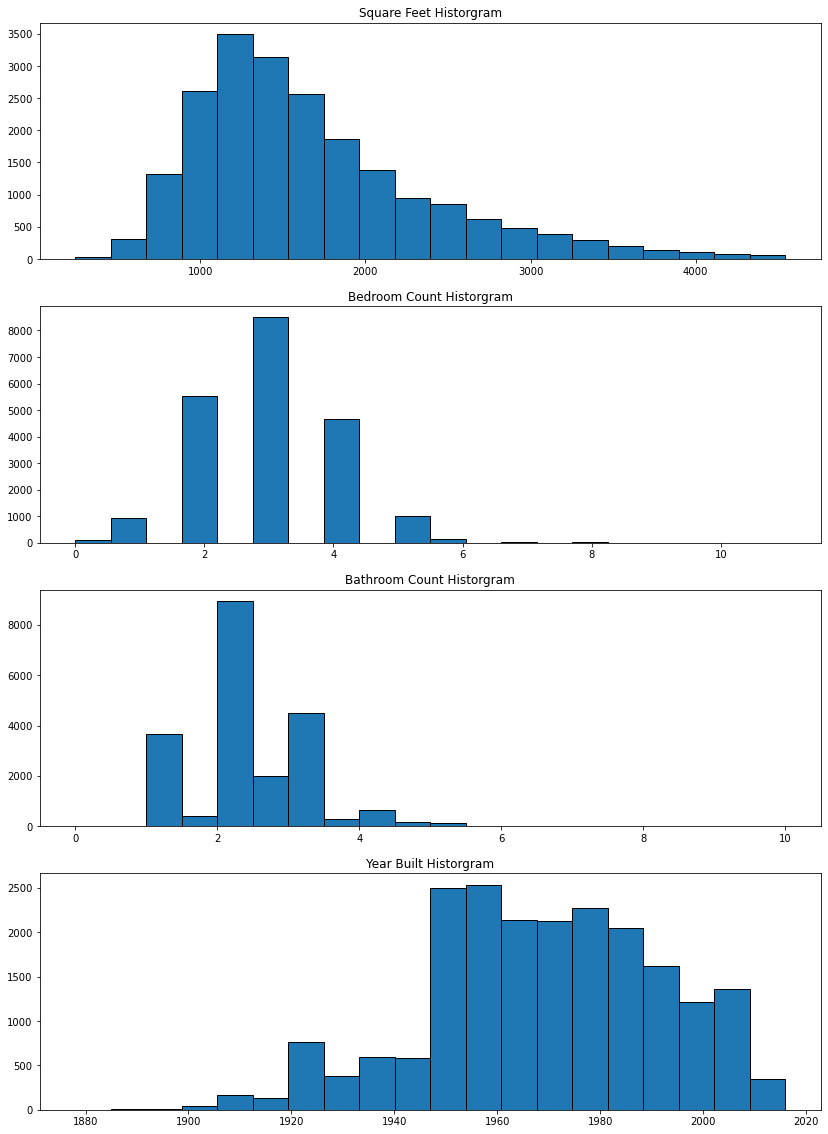

In [23]:
plt.figure(figsize = (14,20))
plt.subplot(4,1,1, title ='Square Feet Historgram')
plt.hist(data=train, x='square_feet', bins = 20, ec = 'black')

plt.subplot(4,1,2, title ='Bedroom Count Historgram')
plt.hist(data=train, x='beds', bins = 20, ec = 'black')

plt.subplot(4,1,3, title ='Bathroom Count Historgram')
plt.hist(data=train, x='baths', bins = 20, ec = 'black')

plt.subplot(4,1,4, title ='Year Built Historgram')
plt.hist(data=train, x='year_built', bins = 20, ec = 'black')


plt.show()


## showing subplot with 20 bin size to show distributions of bedrooms, bathrooms, and square feet

#### Pairplots and Heatmap

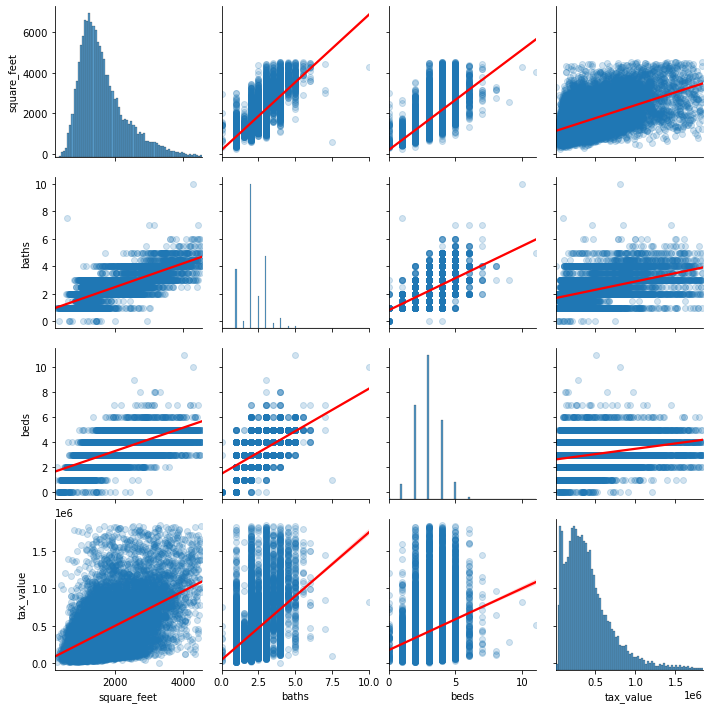

In [24]:
##creating pairplots with regression lines 

cols = ['square_feet', 'baths', 'beds', 'tax_value']
sns.pairplot(train[cols], kind = 'reg', plot_kws={'line_kws':{'color': 'red'},
                                                 'scatter_kws': {'alpha': 0.2}})
plt.show()

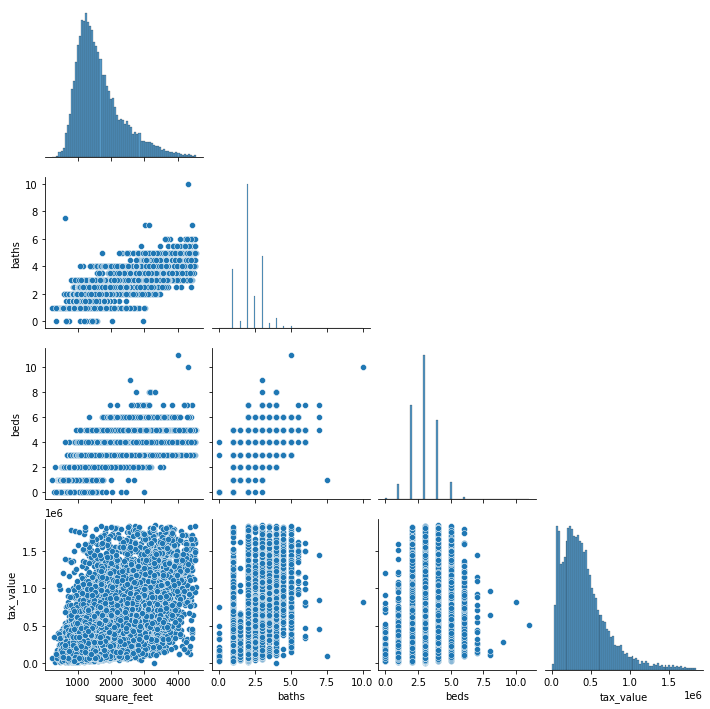

In [25]:
## creating cornered pairplot

sns.pairplot(train[cols], corner = True)
plt.show()

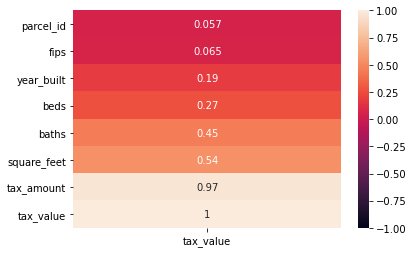

In [26]:
## Heatmap with correlations to target variable

sns.heatmap(train.corr()[['tax_value']].sort_values(by='tax_value'), annot = True,
           vmin = -1, vmax = 1)
plt.show()

#### Explore takeaways
 - Looking at out heatmap we will the 3 features we planned on using have a high positive correlation to our target variable (beds, baths, square_feet
 - Our variable distributions are not completely normal, most are skewed
 - We have more than enough datapoints to continue with statistical testing for signifant relationships

### Statistical Testing

In [27]:
alpha = 0.05 ## <-- Determining alpha value

#### Correlation Tests of Beds, Baths, & Square_Feet
 - To target variable: tax_value

##### Standard Hypothesis for correlation test of all variables

$H_0$ : There is no relationship between these variables

$H_a$ : There is evidence to suggest there is a realtionhip between these two variables

In [28]:
## performing correlation test on square feet because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.square_feet, train.tax_value)
corr, p

(0.5444855278856533, 0.0)

 - With a high correlation of .544 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a  significant realtionship between the square feet of a single unit home and its associated tax value, thus accepting the alternate hypothesis

In [29]:
## performing correlation test on baths because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.baths, train.tax_value)
corr, p

(0.45417552122203797, 0.0)

 - With a high correlation of .454 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a  significant realtionship between the bathroom count of a single unit home and its associated tax value, thus accepting the alternate hypothesis

In [30]:
## performing correlation test on beds because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.beds, train.tax_value)
corr, p

(0.26596004073410573, 0.0)

 - With a decent positive correlation of .26 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a  significant realtionship between the bedroom count of a single unit home and its associated tax value, thus accepting the alternate hypothesis

#### T and P test with determined categories

#### Lots of Square Feet vs Little Square Feet

In [31]:
train.square_feet.mean() ## <--- looking at mean of square footage to
## make our own category of big house vs small house

1669.3029779887786

$H_0$: Houses and their square feet are independent of their tax value price

$H_a$: Houses and their square feet have a significant outcome on their tax value price

In [32]:
big_house = train[train.square_feet >= 1700]  ## <-- creating 2 categories
small_house = train[train.square_feet < 1700] ## using roughly the mean of 
## square feet

In [33]:
t, p = stats.ttest_ind(big_house.tax_value, small_house.tax_value)
t, p

(67.56117563046189, 0.0)

 - With a p value near 0 and less than our alpha 0.05 we can say the square footage of a home does have a signifacnt impact on their tax value price

#### Lots of Bedrooms vs Little Bedrooms

In [34]:
train.beds.mean() ## <-- determine mean amount of bedrooms

2.978516280631084

$H_0$: Houses with a large amount of bedrooms vs a little amount of bedrooms are indepedent of their tax value price

$H_a$: Houses with a large amount of bedrooms vs a little amount of bedrooms are directly and effect of their tax value price

In [35]:
more_beds = train[train.beds >= 3]  ## <-- create categories
less_beds = train[train.beds < 3]

## run test
t, p = stats.ttest_ind(more_beds.tax_value, less_beds.tax_value)
t, p

(26.810293189534203, 1.0635934616693708e-155)

#### Lots of bathrooms vs Little bathrooms

In [36]:
train.baths.mean()  ## <-- determine mean amount of bathrooms

2.2033280583129526

$H_0$: Houses with a large amount of bathrooms vs a little amount of bathrooms are indepedent of their tax value price

$H_a$: Houses with a large amount of bathrooms vs a little amount of bathrooms are directly and effect of their tax value price

In [37]:
more_baths = train[train.baths > 2] ## <-- create categories
less_baths = train[train.baths <= 2]

## run test
t, p = stats.ttest_ind(more_baths.tax_value, less_baths.tax_value)
t, p

(61.06715975932221, 0.0)

#### Statistical Testing Takeaways
 - The features we hypothesized would be good in model building have strong correlations with our target variable and proven to be significant from our correlation tests
 - By running t and p tests on our 3 main features as well after creating categories. We have determined that the 3 main features do have a significant impact on our target variable 
 

## Modeling

In [38]:
## Turning all my y's into dataframe

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

### Establishing Mean and Median Baseline

In [39]:
## tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

## tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

## RMSE of tax_value_pred_mean train and validate scores
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('Baseline')
print('-----------------------------')
print('RMSE using Mean\nTrain/In-Sample: ', round(rmse_train, 4), 
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 4))
print('-----------------------------')

## RMSE of tax_value_pred_median train and validate scores
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')

Baseline
-----------------------------
RMSE using Mean
Train/In-Sample:  307602.83 
Validate/Out-of-Sample:  303586.9147
-----------------------------
RMSE using Median
Train/In-Sample:  314746.9672 
Validate/Out-of-Sample:  310746.3301
-----------------------------
The R squared score for the baseline is -1.398934504237559e-06


 - To beat our baseline, we need RMSE's below 307602 using the mean instead of the median, and an R squared score better than -1.39 x $10^6$

#### LinearRegression/OLS

In [40]:
## we are going to use all three features in X scaled so no subset

## create the model
lm = LinearRegression(normalize = True)

## fit the model to train
lm.fit(X_train_scaled, y_train.tax_value)

## use the model to predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_lm) **(1/2)

## predict validate 
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                y_validate.tax_value_pred_lm) **(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for OLS: {r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}')

RMSE for OLS using LinearRegression
Training/In-Sample:  253120.96031610592 
Validate/Out-of-Sample:  251470.4735562412
------------------------------------------------
R squared score for OLS: 0.3138666804294292


 - Our Linear Regression model beats the baseline in both categories, yay!

#### Lasso & Lars

In [41]:
## we are going to use all three features in X scaled so no subset

## create the model
lars = LassoLars(alpha=1.0)

## fit the model to train
lars.fit(X_train_scaled, y_train.tax_value)

## use the model to predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_lars) **(1/2)

## predict validate 
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                y_validate.tax_value_pred_lars) **(1/2)

print("RMSE for Lasso & Lars \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Lasso & Lars: {r2_score(y_validate.tax_value, y_validate.tax_value_pred_lars)}')

RMSE for Lasso & Lars 
Training/In-Sample:  253121.2333375491 
Validate/Out-of-Sample:  251467.0452464276
------------------------------------------------
R squared score for Lasso & Lars: 0.313885388483105


 - Our Lasso & Lars model does out perform the baseline and results are very close to our Linear Regression model. Let's look at other models

#### TweedieRegressor

In [42]:
## we are going to use all three features in X scaled so no subset

## create the model
glm = TweedieRegressor(power = 0, alpha = 0)

## fit the model to train
glm.fit(X_train_scaled, y_train.tax_value)

## use the model to predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_glm) **(1/2)

## predict validate 
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_glm) **(1/2)

print("RMSE for TweedieRegressor \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for TweedieRegressor: {r2_score(y_validate.tax_value, y_validate.tax_value_pred_glm)}')

RMSE for TweedieRegressor 
Training/In-Sample:  253120.9603161059 
Validate/Out-of-Sample:  251470.47355611826
------------------------------------------------
R squared score for TweedieRegressor: 0.31386668043010013


 - Out TweedieRegressor model outperforms the baseline and has similar performance to both our Lasso Lars and Linear Regression models

#### Polynomial Regression

In [43]:
## getting new set of features using degree 3
pf = PolynomialFeatures(degree = 3)

## fitting and transforming scaled X's for lm2 below
X_train_degree2 = pf.fit_transform(X_train_scaled)
X_validate_degree2 = pf.fit_transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [44]:
## we are going to use all three features in X scaled so no subset

## create the model
lm2 = LinearRegression(normalize = True)

## fit the model to train
lm2.fit(X_train_degree2, y_train.tax_value)

## use the model to predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

## RMSE score for train
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_lm2) **(1/2)

## predict validate 
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                y_validate.tax_value_pred_lm2) **(1/2)

print("RMSE for Polynomial Features w/ degrees 3: \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Polynomial Features: {r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm2)}')

RMSE for Polynomial Features w/ degrees 3: 
Training/In-Sample:  251810.1484719684 
Validate/Out-of-Sample:  251108.2651459018
------------------------------------------------
R squared score for Polynomial Features: 0.3158418171027151


 - Our Polynomial Features model beat the baseline as well. Let's look at all the scores to see which one we want to test 

#### Plotting the Residuals

#### All Models Residuals 

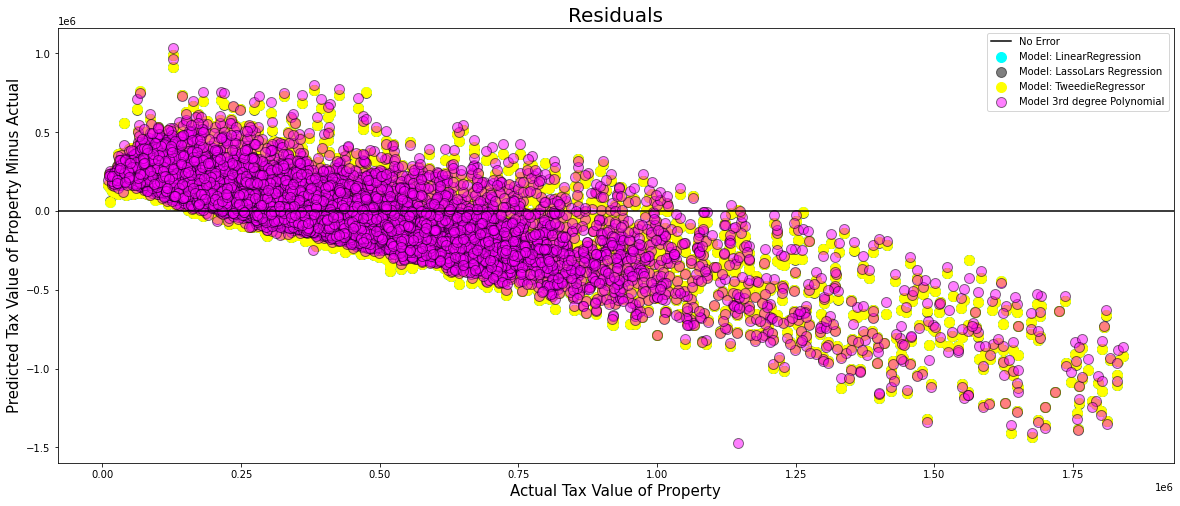

In [45]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=1, color="cyan", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars-y_validate.tax_value, 
            alpha=.5, color="black", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=1, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="magenta", s=100, edgecolors='black', label="Model 3rd degree Polynomial")
plt.legend()

plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})
plt.show()

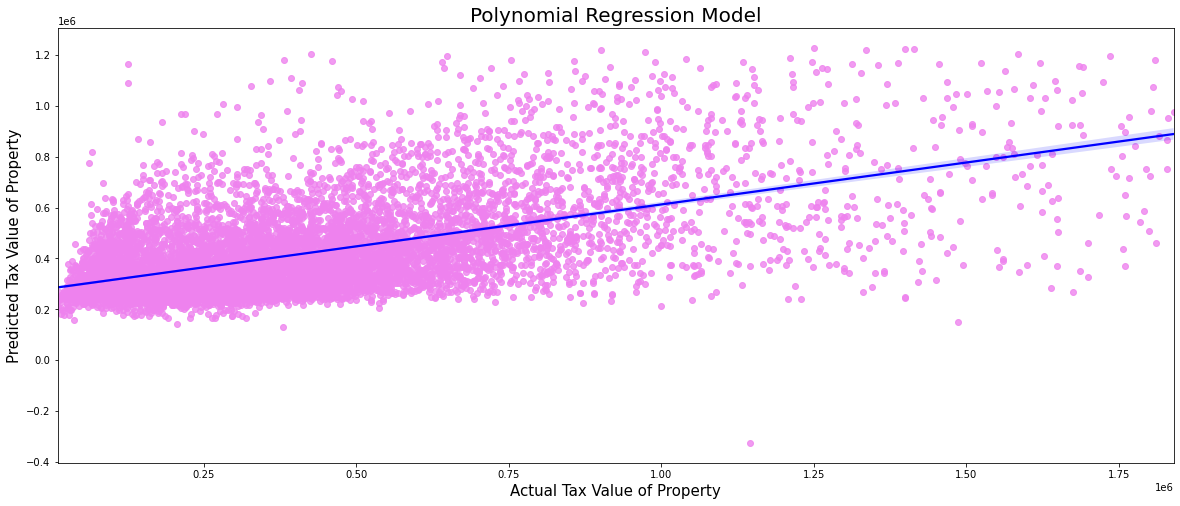

In [70]:
#looks like 3rd degree polynomial did the best, let's visualize that
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.tax_value, y=y_validate.tax_value_pred_lm2, 
            scatter_kws={'color':'violet'}, line_kws={'color':'blue'})
plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property", fontdict={'fontsize':15})
plt.title("Polynomial Regression Model", fontdict={'fontsize': 20})

plt.show()

#### Modeling Takeaways
 - All of my models out perform the baseline however, my Polynomial Regression with 3 degrees performed the best on R squared so this is the one we are going to test

#### Testing Polynomial Regression

In [47]:
print('             BASELINE')
print('-----------------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('-----------------------------------------')

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('-----------------------------------------')
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The r^2 score for baseline is {r2_baseline}')


# predicting on our test model
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)
print('             ')
print('             Our Test Model')
print('-----------------------------------------')
print("RMSE for OLS Polynomial Model w/ 3 degrees\nTest Performance: ", rmse_test)
r2_test_score_lm2 = r2_score(y_test.tax_value, y_test.tax_value_pred_lm2)
print(f'Polynomial Regression (3 degrees) has an R^2 value of {round(r2_test_score_lm2,4)}')

             BASELINE
-----------------------------------------
RMSE using Mean
Train/In-Sample:  251810.1485 
Validate/Out-of-Sample:  251108.2651
-----------------------------------------
RMSE using Median
Train/In-Sample:  307602.83 
Validate/Out-of-Sample:  303586.9147
-----------------------------------------
The r^2 score for baseline is -1.398934504237559e-06
             
             Our Test Model
-----------------------------------------
RMSE for OLS Polynomial Model w/ 3 degrees
Test Performance:  250169.83827042734
Polynomial Regression (3 degrees) has an R^2 value of 0.3557


#### Our Polynomial regression w/ 3 degrees performs better than the baseline and has the highest R squared value so we used it on our test dataset

#### Takeaways from Test/ Final Takeaways
 - Square footage was the best feature for predicting home values because it had the strongest correlation and proved significant with correlation testing
 - The next best features for model prediction where bathroom amount and bedroom count. With more time I'd like to explore more feature engineering to improve the scores of our model
 - Location for example in the real world is a huge factor in value, but we would need more data to use this in our model. Most of the properties were in Los Angeles County

#### Tax Rates for Each County

In [48]:
df = wrangle_zillow()
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30


In [49]:
## Removing unneccessary columns 
cols = ['parcelid', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 
        'taxvaluedollarcnt', 
        'yearbuilt', 'taxamount', 'fips']
zillow_df = df[cols]
zillow_df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,14634203,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0
1,11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
2,11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0
3,11637029,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0
4,11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0


In [50]:
zillow_df = zillow_df.dropna() ## <-- dropping nulls
zillow_df.shape ## <-- checking shape 

(38479, 8)

In [51]:
zillow_df = organize_zillow(zillow_df) ## renaming columns to make my life
## easier 
zillow_df.head() 

,parcel_id,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
0,14634203,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0
1,11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
2,11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0
3,11637029,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0
4,11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0


In [52]:
zillow_df = delete_outliers(zillow_df) ## <-- removing outliers
zillow_df.shape ## <-- rechecking shape

(37239, 8)

In [53]:
zillow_df = zillow_df.drop(columns = 'year_built') ## dropping unneccessary column
zillow_df.head()

,parcel_id,beds,baths,square_feet,tax_value,tax_amount,fips
0,14634203,3.0,2.0,1125.0,289445.0,3490.16,6059.0
1,11721753,3.0,2.0,1316.0,205123.0,2627.48,6037.0
2,11289917,3.0,2.0,1458.0,136104.0,2319.90,6037.0
3,11637029,3.0,2.0,1766.0,810694.0,9407.01,6037.0
4,11705026,2.0,1.0,1421.0,35606.0,543.69,6037.0


In [54]:
## making a tax rate column by dividing tax_value from tax_amount

zillow_df['tax_rate'] = zillow_df['tax_amount'] / zillow_df['tax_value']
zillow_df.head()  

,parcel_id,beds,baths,square_feet,tax_value,tax_amount,fips,tax_rate
0,14634203,3.0,2.0,1125.0,289445.0,3490.16,6059.0,0.012058
1,11721753,3.0,2.0,1316.0,205123.0,2627.48,6037.0,0.012809
2,11289917,3.0,2.0,1458.0,136104.0,2319.90,6037.0,0.017045
3,11637029,3.0,2.0,1766.0,810694.0,9407.01,6037.0,0.011604
4,11705026,2.0,1.0,1421.0,35606.0,543.69,6037.0,0.015270


In [55]:
## Making county column based on fips column using the associated ID's

zillow_df['County'] = zillow_df['fips'].map({6037: 'Los Angeles', 
                                             6059: 'Orange', 
                                             6111: 'Ventura'})
zillow_df.head()

,parcel_id,beds,baths,square_feet,tax_value,tax_amount,fips,tax_rate,County
0,14634203,3.0,2.0,1125.0,289445.0,3490.16,6059.0,0.012058,Orange
1,11721753,3.0,2.0,1316.0,205123.0,2627.48,6037.0,0.012809,Los Angeles
2,11289917,3.0,2.0,1458.0,136104.0,2319.90,6037.0,0.017045,Los Angeles
3,11637029,3.0,2.0,1766.0,810694.0,9407.01,6037.0,0.011604,Los Angeles
4,11705026,2.0,1.0,1421.0,35606.0,543.69,6037.0,0.015270,Los Angeles


In [56]:
## Making a dataframe with the mean tax rate for each county

tax_rate_county = pd.DataFrame(round(zillow_df.groupby('County').tax_rate.mean(), 3)* 100)
tax_rate_county.columns = ['tax_percent']
tax_rate_county

,tax_percent
County,
Los Angeles,1.4
Orange,1.2
Ventura,1.2


In [57]:
## making masked dataframes for subplots 

la_tax = zillow_df[zillow_df.County == 'Los Angeles'].tax_rate
orange_tax = zillow_df[zillow_df.County == 'Orange'].tax_rate
ventura_tax = zillow_df[zillow_df.County == 'Ventura'].tax_rate

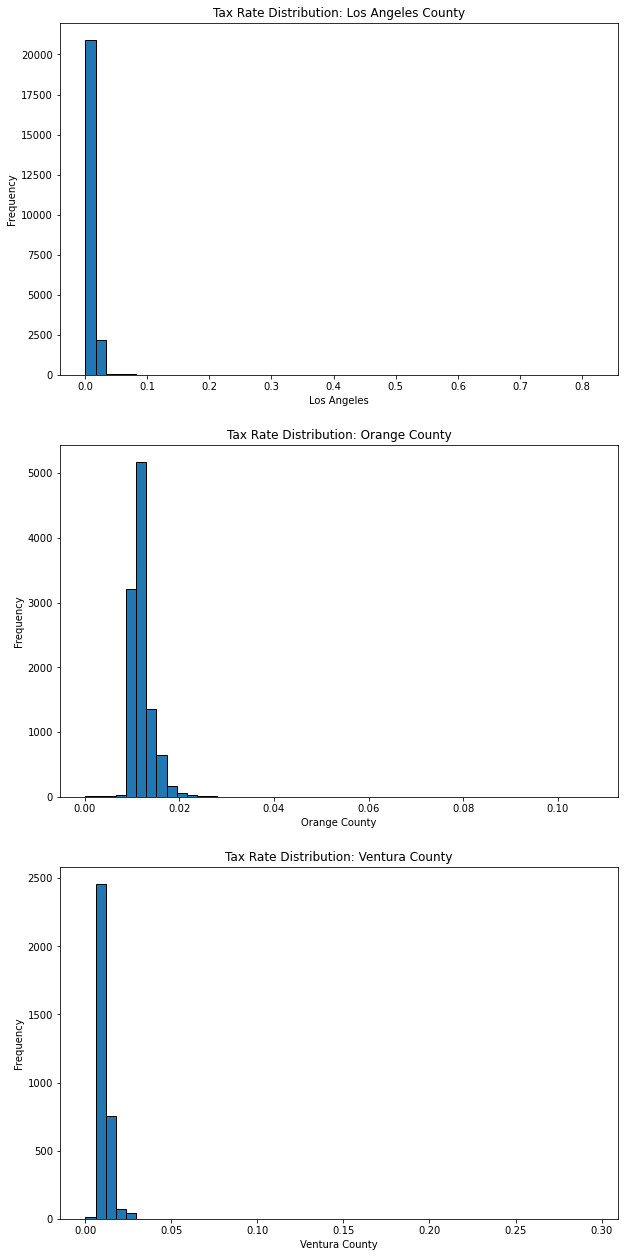

In [58]:
plt.figure(figsize=(10,22))
plt.subplot(3,1,1, xlabel = 'Los Angeles', ylabel = 'Frequency', title='Tax Rate Distribution: Los Angeles County')
plt.hist(data=zillow_df[zillow_df.fips == 6037], bins = 50, x='tax_rate',ec='black')

plt.subplot(3,1,2, xlabel = 'Orange County', ylabel = 'Frequency', title='Tax Rate Distribution: Orange County')
plt.hist(data=zillow_df[zillow_df.fips == 6059], bins = 50, x='tax_rate', ec='black')

plt.subplot(3,1,3, xlabel = 'Ventura County', ylabel = 'Frequency', title='Tax Rate Distribution: Ventura County')
plt.hist(data=zillow_df[zillow_df.fips == 6111], bins = 50, x='tax_rate',ec='black')

plt.show()

In [59]:
tax_rate_df = zillow_df
tax_rate_df.head()

,parcel_id,beds,baths,square_feet,tax_value,tax_amount,fips,tax_rate,County
0,14634203,3.0,2.0,1125.0,289445.0,3490.16,6059.0,0.012058,Orange
1,11721753,3.0,2.0,1316.0,205123.0,2627.48,6037.0,0.012809,Los Angeles
2,11289917,3.0,2.0,1458.0,136104.0,2319.90,6037.0,0.017045,Los Angeles
3,11637029,3.0,2.0,1766.0,810694.0,9407.01,6037.0,0.011604,Los Angeles
4,11705026,2.0,1.0,1421.0,35606.0,543.69,6037.0,0.015270,Los Angeles


In [60]:
tax_rate_df.to_csv('Properties_With_Tax_Rates.csv')  ## <-- turning into a csv